# Image Classification with a Multi-Layer Perceptron

Notebook created by [Santi Pascual](https://github.com/santi-pdp) for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) (2019) and updated by [Daniel Fojo](https://www.linkedin.com/in/daniel-fojo/), [Xavier Giro](https://imatge.upc.edu/web/people/xavier-giro), [Pol Caselles](https://www.linkedin.com/in/pcaselles/), [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/) and [Juan José Nieto](https://www.linkedin.com/in/juan-jose-nieto-salas/).

Based on an original version in Keras created by [Miriam Bellver](https://imatge.upc.edu/web/people/miriam-bellver) for the [Barcelona Technology School](https://barcelonatechnologyschool.com/master/master-in-big-data-solutions/) (BTS) in 2018.

The problem we are trying to solve here is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. As you become a machine learning practitioner, you will see MNIST come up over and over again, in scientific papers, blog posts, and so on.


In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple
from torchvision import datasets, transforms
from torchvision.utils import make_grid

To ensure reproducibility of the experiments, we can set the seed to a fixed number.

In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

In [3]:
# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# whenever we send something to the selected device (X.to(device)) we already use
# either CPU or CUDA (GPU). Importantly...
# The .to() operation is in-place for nn.Module's, so network.to(device) suffices
# The .to() operation is NOT in.place for tensors, so we must assign the result
# to some tensor, like: X = X.to(device)


### Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.


In [18]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-4,
    'log_interval':100,
}

### Defining the PyTorch Dataset and the DataLoader

The [PyTorch Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an inheritable `class` that helps us defining what source of data do we have (image, audio, text, ...) and how to load it (overriding the `__getitem__` function). The MNIST dataset is easible accessible from it.

The [PyTorch DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator that provides batching and shuffling capabilities, among others.

Each of the datasets, `mnist_trainset` and `mnist_testset`, is composed by images and labels. The model will be trained with the former and evaluated with the latter. Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging from 0 to 9. There is a one-to-one correspondence between the images and the labels.

In [5]:
transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


# Dataset initializations

mnist_trainset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms)

mnist_testset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms
)

# Dataloders initialization

train_loader = torch.utils.data.DataLoader(
    dataset=mnist_trainset,
    batch_size=hparams['batch_size'],
    shuffle=True,
    drop_last=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=mnist_testset,
    batch_size=hparams['test_batch_size'],
    shuffle=False,
    drop_last=True,
)

100%|██████████| 9912422/9912422 [00:00<00:00, 92870714.21it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 121256950.77it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28129731.50it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23993109.28it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
# We can retrieve a sample from the dataset by simply indexing it
img, label = mnist_trainset[0]
print('Img shape: ', img.shape)
print('Label: ', label)

# Similarly, we can sample a BATCH from the dataloader by running over its iterator
iter_ = iter(train_loader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} grayscale images ({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([1, 28, 28])
Label:  5
Batch Img shape:  torch.Size([64, 1, 28, 28])
Batch Label shape:  torch.Size([64])
The Batched tensors return a collection of 64 grayscale images (1 channel, 28 height pixels, 28 width pixels)
In the case of the labels, we obtain 64 batched integers, one per image


And now let's look at the kind of images we are dealing with:


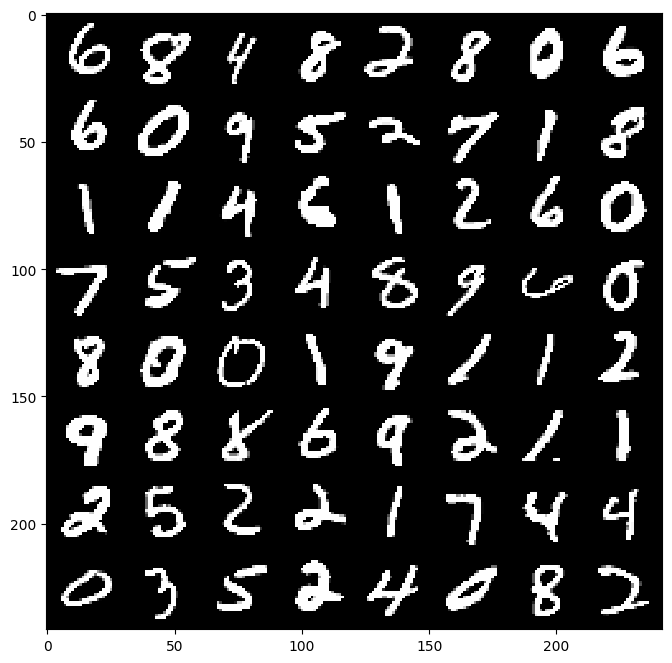

In [7]:
# make_grid is a function from the torchvision package that transforms a batch
# of images to a grid of images
img_grid = make_grid(bimg)

plt.figure(figsize = (8, 8))
plt.imshow(img_grid.permute(1, 2, 0), interpolation='nearest')

### BAAAAM, we've got some numbers there

# Training a Multi-Layer Perceptron (MLP)

Now that we have the dataset loaded and prepared, let's get some deep stuff spinning.

Our workflow will be as follow: first we will train our neural network with the training data, loaded from the constructed `train_loader`. The network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_loader` images, and we will verify if these predictions match the labels from `test_loader`.

### Exercise 1

For the time being, we will use a very simple network. It consists of a sequence of two `nn.Linear` layers, which are densely-connected (also called "fully-connected") neural layers. The last layer is a 10-way `nn.LogSoftmax` layer, which means it will return an array of 10 log-probability scores. Each score will be the probability that the current digit image belongs to one of our 10 digit classes. Please fill in the network definition below.

In [8]:
# TODO: Define a variable 'network' by instantiating a PyTorch sequential model
# https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential
# Add a (1) nn.Linear hidden layer with 128 neurons, (2) a nn.ReLU,
# (3) the output nn.Linear and (4) the output nn.LogSoftmax
# NOTE: Consider the 'num_inputs', 'hidden_size', and 'num_classes' parameters
# defined above as hyper-params
network = nn.Sequential(
    nn.Linear(hparams['num_inputs'], hparams['hidden_size']),# (1) nn.Linear hidden layer with 128 neurons
    nn.ReLU(),# (2) nn.ReLU activation function
    nn.Linear(hparams['hidden_size'], hparams['num_classes']),# (3) the output nn.Linear
    nn.LogSoftmax(dim=1)# (4) the output nn.LogSoftmax
)


network.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
)

Now we can check which is the architecture of the network, and the number of parameters of each layer with the following helper function:

In [9]:
def get_nn_nparams(net: torch.nn.Module) -> int:
  """
  Function that returns all parameters regardless of the require_grad value.
  https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6
  """
  return sum([torch.numel(p) for p in list(net.parameters())])


print(network)
print('Num params: ', get_nn_nparams(network))

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
  (3): LogSoftmax(dim=1)
)
Num params:  101770


### Exercise 2

To make our network ready for training, we need to pick three more things:

*    **A loss function**: this is how the network will be able to measure how good a job works on its training data, and thus how it will be able to steer itself in the right direction. **Check the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html) for the negative log likelihood loss for multi-class classification from the functional API.**
*   **An optimizer**: this is the mechanism through which the network will update itself based on the data it sees and its loss function. **Check the [PyTorch documentation](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop) and find the RMSprop optimizer to use it.**
*   **Metrics to monitor during training and testing**. Here we will only care about accuracy (the fraction of the images that were correctly classified). **Define the accuracy function to return, for a batch, the count of correct predictions (hence same prediction as the label).**




In [10]:
# Import a functional API for the loss function (use this one !!)
# https://pytorch.org/docs/stable/nn.functional.html#nll-loss
# TODO: Specify the loss function. Don't instantiate it, just assign it to 'criterion'
criterion = torch.nn.functional.nll_loss


# https://pytorch.org/docs/stable/optim.html#torch.optim.RMSprop
# TODO: Create the optimizer
optimizer = torch.optim.RMSprop(network.parameters(), lr=hparams['learning_rate'])

def compute_accuracy(predicted_batch: torch.Tensor, label_batch: torch.Tensor) -> int:
    """
    Define the Accuracy metric in the function below by:
      (1) obtain the maximum for each predicted element in the batch to get the
        class (it is the maximum index of the num_classes array per batch sample)
        (look at torch.argmax in the PyTorch documentation)
      (2) compare the predicted class index with the index in its corresponding
        neighbor within label_batch
      (3) sum up the number of affirmative comparisons and return the summation

    Parameters:
    -----------
    predicted_batch: torch.Tensor shape: [BATCH_SIZE, N_CLASSES]
        Batch of predictions
    label_batch: torch.Tensor shape: [BATCH_SIZE, 1]
        Batch of labels / ground truths.
    """
    pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    acum = pred.eq(label_batch.view_as(pred)).sum().item()
    return acum


### Exercise 3
Now, we will define the training and testing functions. In each of them we will iterate over the corresponding data_loader.

Since the input of the network requires a input vector of shape [BATCH_SIZE, H*W], we must rearrange the dimensions of the images. We will use `reshape()` to flatten the 2D images into 1D vectors.

In [11]:
def train_epoch(
        train_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        optimizer: torch.optim,
        criterion: torch.nn.functional,
        log_interval: int,
        ) -> Tuple[float, float]:

    # Activate the train=True flag inside the model
    network.train()

    avg_loss = None
    acc = 0.
    avg_weight = 0.1
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move input data and labels to the device
        data, target = data.to(device), target.to(device)

        # Set network gradients to 0.
        optimizer.zero_grad()

        # TODO: rearrange the data dimension
        data = data.view(data.size(0), -1)

        # Forward batch of images through the network
        output = network(data)

        # Compute loss
        loss = criterion(output, target)

        # Compute backpropagation
        loss.backward()

        # Update parameters of the network
        optimizer.step()

        # Compute metrics
        acc += compute_accuracy(output, target)
        if avg_loss:
            avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
        else:
            avg_loss = loss.item()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_acc = 100. * acc / len(train_loader.dataset)

    return avg_loss, avg_acc

In [13]:
@torch.no_grad() # decorator: avoid computing gradients
def test_epoch(
        test_loader: torch.utils.data.DataLoader,
        network: torch.nn.Module,
        ) -> Tuple[float, float]:

    # Dectivate the train=True flag inside the model
    network.eval()

    test_loss = 0
    acc = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # TODO
        data = data.view(data.size(0), -1)

        output = network(data)

        # Apply the loss criterion and accumulate the loss
        test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

        # WARNING: If you are using older Torch versions, the previous call may need to be replaced by
        # test_loss += criterion(output, target, size_average=False).item()

        # compute number of correct predictions in the batch
        acc += compute_accuracy(output, target)

    test_loss /= len(test_loader.dataset)
    # Average accuracy across all correct predictions batches now
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

### Exercise 4

Now that the `network` and the training and test functions are good to go epoch by epoch, build the loop to make as many as `hparams['num_epochs']` epochs by alternating the train and test phases. Check what these functions return and store the resulting values in lists that will be used to plot the results in the later cell.

In [16]:
# Init lists to save the evolution of the training & test losses/accuracy.
train_losses = []
test_losses = []
train_accs = []
test_accs = []

# For each epoch
for epoch in range(hparams['num_epochs']):

    # Compute & save the average training loss for the current epoch
    train_loss, train_acc = train_epoch(train_loader, network, optimizer, criterion, hparams["log_interval"])
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # TODO: Compute & save the average test loss & accuracy for the current epoch
    # HELP: Review the functions previously defined to implement the train/test epochs
    test_loss, test_accuracy = test_epoch(test_loader, network)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.186497
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.174166
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.151095
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.305046
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.244765
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.215075
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.125589
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.284264
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.159383
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.072459

Test set: Average loss: 0.1983, Accuracy: 9441/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.109419
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.165810
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.091778
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.149769
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.244936
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.138957
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.146352
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.108132
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.244954
T

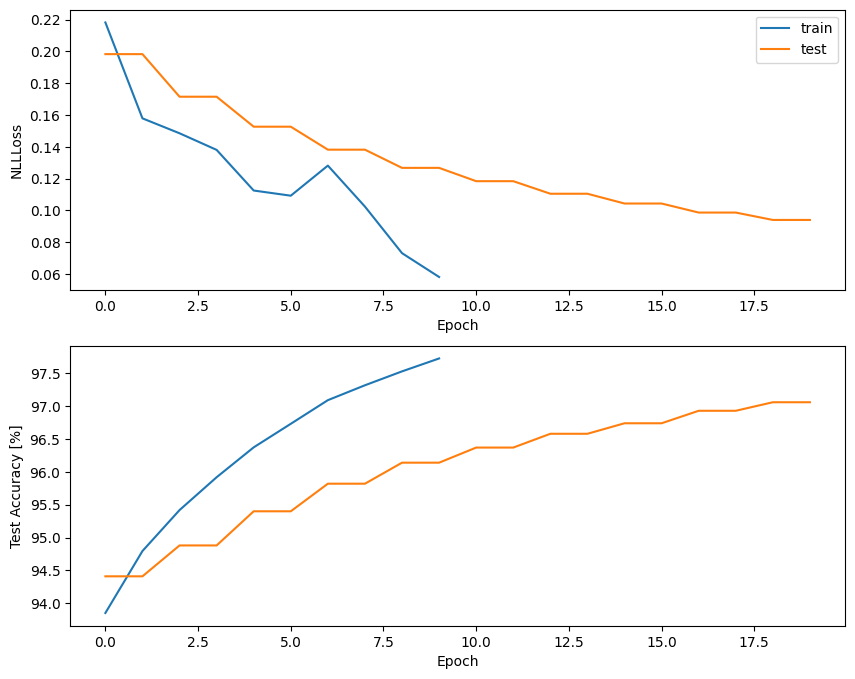

In [17]:
# Plot the plots of the learning curves
plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('NLLLoss')
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')

#### References

[1] https://github.com/pytorch/examples/blob/master/mnist/main.py